## essentials

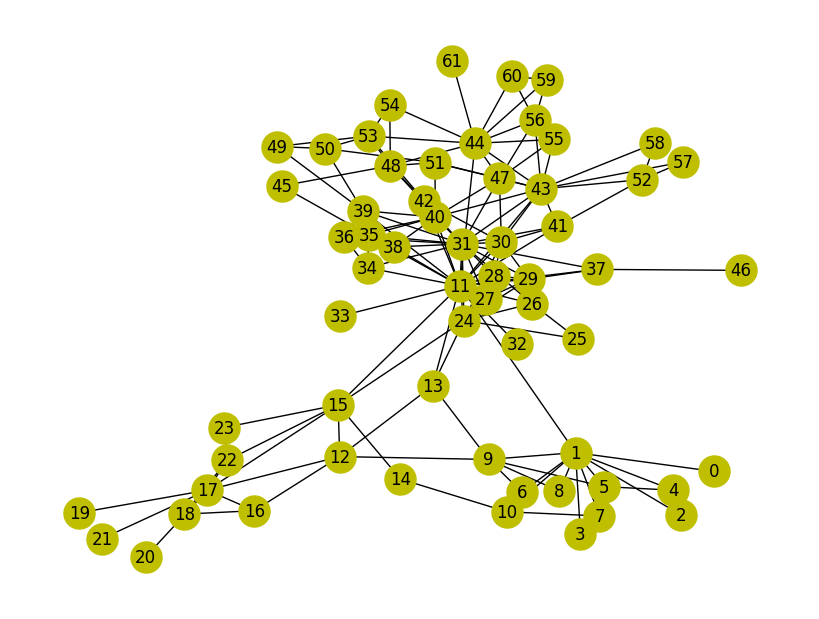

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

df = pd.read_csv('../data/edges.csv', skiprows=1, header=None)
# display(df)
edges = [tuple(x) for x in df.values]

G = nx.Graph()
G.add_edges_from(edges)
layout = nx.spring_layout(G, seed=42)
fig = plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='y', node_size=500, pos =layout)

## trial -1

### betweeness centrality sorted

In [2]:
betweenness = nx.betweenness_centrality(G)
betweeness_sorted = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
#access only the node names
betweeness_nodes = [x[0] for x in betweeness_sorted]
betweeness_nodes[:5]

[11, 1, 15, 44, 43]

In [3]:
#reading the csv file that contains the plci
df = pd.read_csv('../data/model_output_full.csv', skiprows=1, header=None)

betw = dict(zip(df[10], df[7]))
#sort them based on the values
betw_sorted = sorted(betw.items(), key=lambda x: x[1], reverse=True)
betw_nodes =[x[0] for x in betw_sorted]
betw_nodes[:5]

[11, 1, 15, 44, 43]

In [4]:
#do the same but for percolation on column 9
perc = dict(zip(df[10], df[9]))
perc_sorted = sorted(perc.items(), key=lambda x: x[1], reverse=True)
perc_nodes =[x[0] for x in perc_sorted]
perc_nodes[:5]

[17, 1, 31, 9, 29]

In [5]:
c=0
for i in range(62):
    if betw_nodes[i]!=betweeness_nodes[i]:
        print(betw_nodes[i],"on the %d position"%i)
        c+=1
c

4 on the 40 position
6 on the 41 position
8 on the 42 position
25 on the 43 position
27 on the 44 position
28 on the 45 position
55 on the 46 position
59 on the 47 position
2 on the 48 position
3 on the 49 position
32 on the 50 position
33 on the 51 position
23 on the 52 position
19 on the 53 position
20 on the 54 position
21 on the 55 position
46 on the 56 position
57 on the 57 position
58 on the 58 position


19

### Complex centrality sorted

### extraction

In [6]:
#reading the csv file that contains the plci
df = pd.read_csv('../data/model_output_full.csv', skiprows=1, header=None)
#putting col 10 as keys and col 4 as values in a dictionary
plci = dict(zip(df[10], df[4]))
#sort them based on the values
plci_sorted = sorted(plci.items(), key=lambda x: x[1], reverse=True)
plci_nodes =[x[0] for x in plci_sorted]

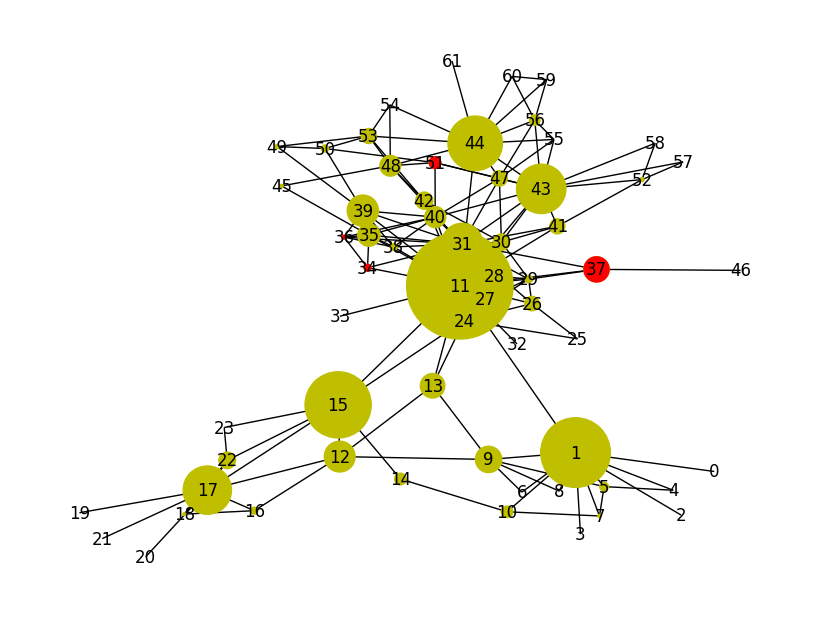

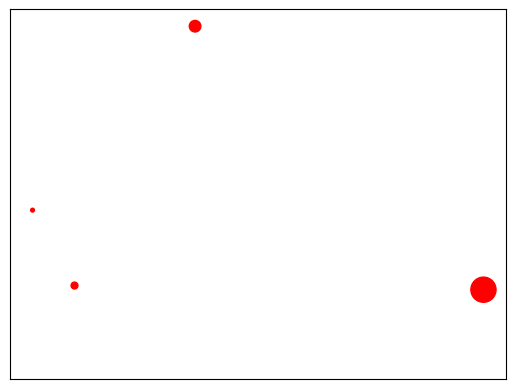

In [7]:
plci_nodes[:5]
#plot the graph and color the top 5 nodes based on plci and size based on betweeness

top_5_plci_nodes = plci_nodes[:5]
top_5_sizes = [betweenness[v] * 10000 for v in top_5_plci_nodes]

fig = plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='y', node_size=[v * 10000 for v in betweenness.values()], pos=layout)
nx.draw_networkx_nodes(G, pos=layout, nodelist=top_5_plci_nodes, node_color='r', node_size=top_5_sizes)
plt.show()
nx.draw_networkx_nodes(G, pos=layout, nodelist=top_5_plci_nodes, node_color='r', node_size=top_5_sizes)
plt.show()

### The attack 

In [8]:
def compute_lcc(G):
    if G.number_of_nodes() == 0:
        return 0
    else:
        max_comp= max(nx.connected_components(G), key=len)
        return len(max_comp)
    
def compute_i(G, i):
    if G.number_of_nodes() == 0:
        return 0
    else:
        max_comp= max(nx.connected_components(G), key=len)
        return len(max_comp)/i

def attack(G, sorted_nodes):
    LCC={}#key is the # of nnodes removed, value is the size of the largest connected component
    Inter={}
    fix_size=G.number_of_nodes()
    G_copy = G.copy()
    for i in range(len(sorted_nodes)):
        G_copy.remove_node(sorted_nodes[i])
        lcc = compute_lcc(G_copy)
        i_index= compute_i(G_copy, fix_size)
        LCC[i+1] = lcc
        Inter[i+1]=i_index
    return LCC, Inter

bet_attack =attack(G, betweeness_nodes)
plci_attack=attack(G, plci_nodes)
per_attack=attack(G, perc_nodes)
# compute_lcc(G)

In [9]:
degrees={}
for n in G.nodes():
    degrees[n]=G.degree(n)
# degrees
#srt degrees by keys NOT values
# degrees

In [37]:
#i wanna plot the bet_attack and plci_attack on same plot where keys are the x axis and values are on y
fig = plt.figure(figsize=(8, 6))
plt.plot(list(bet_attack.keys()), list(bet_attack.values()), label='Betweeness')
plt.plot(list(plci_attack.keys()), list(plci_attack.values()), label='PLCI')
plt.plot(list(per_attack.keys()), list(per_attack.values()), label='Percolation')
# plt.plot(list(degrees.keys()), list(degrees.values()), label='Degree')
plt.legend()
plt.xlabel('Number of nodes removed')
plt.ylabel('i_index')
plt.show()

AttributeError: 'tuple' object has no attribute 'keys'

<Figure size 800x600 with 0 Axes>

0.5241733033240997

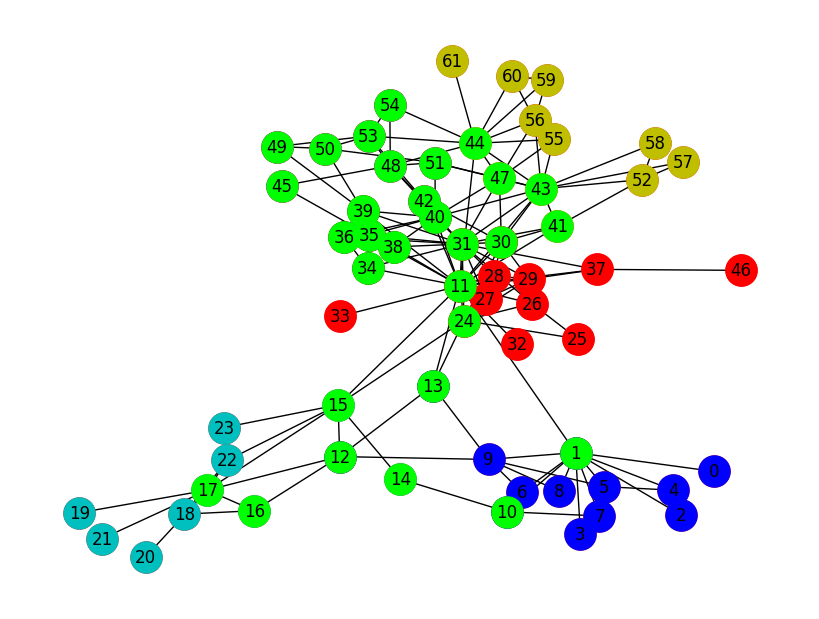

In [26]:
def get_boundary_nodes(G, partition):   
    '''takes graph and partiton - list of sets of nodes - as input and returns the boundary nodes in a list'''
    boundary_edges = set()
    for i in range(len(partition)):
        for j in range(len(partition)):
            if i != j:
                boundary_edges.update(nx.edge_boundary(G, partition[i], partition[j]))

    b_nodes = []
    for i in range(len(boundary_nodes)):
        b_nodes.append(list(boundary_nodes)[i][0])
        b_nodes.append(list(boundary_nodes)[i][1])
    b_nodes = list(set(b_nodes))
    return b_nodes

#apply louvain on the ntework
partition = nx.community.louvain_communities(G, seed=10)
partition
#access boundary nodes
boundary_nodes = set()
for i in range(len(partition)):
    for j in range(len(partition)):
        if i != j:
            boundary_nodes.update(nx.edge_boundary(G, partition[i], partition[j]))

#turn all number in the tuples in boundary_nodes to elements of list b_nodes
b_nodes = []
for i in range(len(boundary_nodes)):
    b_nodes.append(list(boundary_nodes)[i][0])
    b_nodes.append(list(boundary_nodes)[i][1])
#make all elements unique
b_nodes = list(set(b_nodes))
#color boundary nodes in green and the rest in red
# fig = plt.figure(figsize=(8, 6))
# nx.draw(G, with_labels=True, node_color='r', node_size=500, pos=layout)
# nx.draw_networkx_nodes(G, pos=layout, nodelist=b_nodes, node_color='g', node_size=500)

#color graph based on the partition
fig = plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='r', node_size=500, pos=layout)
#create a lis of 20 colors
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'pink', 'brown', 'purple', 'gray', 'olive', 'cyan', 'lime', 'teal', 'lavender', 'turquoise', 'tan'] 
for i in range(len(partition)):
    nx.draw_networkx_nodes(G, pos=layout, nodelist=list(partition[i]), node_color=colors[i], node_size=500)
nx.draw_networkx_nodes(G, pos=layout, nodelist=b_nodes, node_color='lime', node_size=500)

#compute the modularity of the partition
nx.community.quality.modularity(G, partition)

In [48]:
import time

def partition_list(input_list, num=100):
    n = len(input_list) // num
    remainder = len(input_list) % num
    partitions = []
    for i in range(num):
        start = i * n + min(i, remainder)
        end = start + n + (i < remainder)
        partitions.append(input_list[start:end])
    return partitions

def attack_pro(g, sorted_nodes, batch_num=100):
    G=g.copy()  
    N=G.number_of_nodes()
    pi = partition_list(sorted_nodes, batch_num)
    # print(len(pi))

    lcc=0;norm_lcc=0;i_index=0;e=0
    norm_LCC={};LCC={};Inter={};E={}
    R=[]; InterE=[]

    t=time.time()

    for batch in range((len(pi))): #looping through each batch
        for node in pi[batch]:
            G.remove_node(node)
            lcc = compute_lcc(G)
            i_index= compute_i(G, N)
            norm_lcc = lcc/N
            e = nx.algorithms.global_efficiency(G)

            R.append(norm_lcc)
            InterE.append(e)

        norm_LCC[batch]=norm_lcc
        LCC[batch]=lcc
        Inter[batch]=i_index
        E[batch]=e

    e=time.time()
    t=e-t

    #R at halftime doesn not hold according to formula
    R=sum(R)/len(R)
    InterE=sum(InterE)/len(InterE)

    return norm_LCC, Inter, E, R, InterE, t 

In [45]:
# def compute_local_bewteenness(G, partition):
#     '''takes a graph and a partition as input and returns a dictionary with nodes as keys and local betweenness as values'''
#     local_betweenness = {}
#     for i in range(len(partition)):
#         sub = G.subgraph(partition[i])
#         betweenness = nx.betweenness_centrality(sub)    
#         local_betweenness.update(betweenness)
#     return local_betweenness

# compute_local_bewteenness(G, partition)

l=[i for i in range (237)]
def partition_list(input_list, num):
    n = len(input_list) // num
    remainder = len(input_list) % num
    partitions = []
    for i in range(num):
        start = i * n + min(i, remainder)
        end = start + n + (i < remainder)
        partitions.append(input_list[start:end])
    return partitions
len(partition_list(l, 100))
partition_list(l, 100)

[[0, 1, 2],
 [3, 4, 5],
 [6, 7, 8],
 [9, 10, 11],
 [12, 13, 14],
 [15, 16, 17],
 [18, 19, 20],
 [21, 22, 23],
 [24, 25, 26],
 [27, 28, 29],
 [30, 31, 32],
 [33, 34, 35],
 [36, 37, 38],
 [39, 40, 41],
 [42, 43, 44],
 [45, 46, 47],
 [48, 49, 50],
 [51, 52, 53],
 [54, 55, 56],
 [57, 58, 59],
 [60, 61, 62],
 [63, 64, 65],
 [66, 67, 68],
 [69, 70, 71],
 [72, 73, 74],
 [75, 76, 77],
 [78, 79, 80],
 [81, 82, 83],
 [84, 85, 86],
 [87, 88, 89],
 [90, 91, 92],
 [93, 94, 95],
 [96, 97, 98],
 [99, 100, 101],
 [102, 103, 104],
 [105, 106, 107],
 [108, 109, 110],
 [111, 112],
 [113, 114],
 [115, 116],
 [117, 118],
 [119, 120],
 [121, 122],
 [123, 124],
 [125, 126],
 [127, 128],
 [129, 130],
 [131, 132],
 [133, 134],
 [135, 136],
 [137, 138],
 [139, 140],
 [141, 142],
 [143, 144],
 [145, 146],
 [147, 148],
 [149, 150],
 [151, 152],
 [153, 154],
 [155, 156],
 [157, 158],
 [159, 160],
 [161, 162],
 [163, 164],
 [165, 166],
 [167, 168],
 [169, 170],
 [171, 172],
 [173, 174],
 [175, 176],
 [177, 178],
 [

In [ ]:
def get_boundary_nodes(G, partition):   
    '''takes graph and partiton - list of sets of nodes - as input and returns the boundary nodes in a list'''
    boundary_edges = set()
    for i in range(len(partition)):
        for j in range(len(partition)):
            if i != j:
                boundary_edges.update(nx.edge_boundary(G, partition[i], partition[j]))

    b_nodes = []
    for i in range(len(boundary_nodes)):
        b_nodes.append(list(boundary_nodes)[i][0])
        b_nodes.append(list(boundary_nodes)[i][1])
    b_nodes = list(set(b_nodes))
    return b_nodes


# def community_attack(g:nx.Graph, partition:list, sorted_central:list):
#     '''
#     take a graph, the partition done after using a community based algorithm, and a list of nodes sorted based on their centrality
#     returns: dictionaries where keys are the number of nodes removed and values are the LCCs normalized/efficiency...
#     '''
#     #stopping criteria is either LCC=0 or boundary nodes left are {}
#     G=g.copy()

#     boundary_nodes = get_boundary_nodes(g, partition)
#     B=len(boundary_nodes ); N=G.number_of_nodes()

#     LCC={}
#     Inter={}
#     Eff={}
#     R=[]
#     sorted_central_q=sorted_central.copy()  

#     for i in range(N): #looping through all nodes
#         if len(boundary_nodes) !=0:
#             if sorted_central[i] in boundary_nodes:
#                 G.remove(sorted_central[i])
#                 sorted_central_q.remove(sorted_central[i])
#                 boundary_nodes.remove(sorted_central[i])
#                 B-=1
#             else: 
#                 continue
#         else: #now we have N-B nodes left in the queue
#             G.remove(sorted_central_q[0]) #they're sorted and everytime im removing the first one
#             sorted_central_q.remove(sorted_central_q[0])
#         lcc = compute_lcc(G)
#         i_index= compute_i(G, N)
# eff = 

def sort_bounded(sorted_list, boundary_list):
    '''
    takes a sorted list and a list of boundary nodes and returns a sorted list where the boundary nodes are at the start
    '''
    new_list=[]
    sorted_list_q=sorted_list.copy()
    for i in range(len(sorted_list)):
        if sorted_list[i] in boundary_list:
            new_list.append(sorted_list[i])
            sorted_list_q.remove(sorted_list[i])
        else:
            continue
    for i in range(len(sorted_list_q)):
        new_list.append(sorted_list_q[i])
        return new_list

#WITHOUT RECALCULATION  
def community_attack_pro(g:nx.Graph, partition:list, sorted_central:list, batch_num=100):
    '''
    take a graph, the partition done after using a community based algorithm, and a list of nodes sorted based on their centrality
    returns: dictionaries where keys are the number of nodes removed and values are the LCCs normalized/efficiency...
    '''
    #stopping criteria is either LCC=0 or boundary nodes left are {}
    G=g.copy()  
    N=G.number_of_nodes()
    get_boundary_nodes(g, partition)
    sorted_list = sort_bounded(sorted_central, boundary_nodes)
    pi = partition_list(sorted_list, batch_num)

    lcc=0;norm_lcc=0;i_index=0;e=0
    norm_LCC={};LCC={};Inter={};E={}
    R=[]; InterE=[]

    t=time.time()

    for batch in range((len(pi))): #looping through each batch
        for node in pi[batch]:
            G.remove_node(node)
            lcc = compute_lcc(G)
            i_index= compute_i(G, N)
            norm_lcc = lcc/N
            e = nx.algorithms.global_efficiency(G)

            R.append(norm_lcc)
            InterE.append(e)

        norm_LCC[batch]=norm_lcc
        LCC[batch]=lcc
        Inter[batch]=i_index
        E[batch]=e

    e=time.time()
    t=e-t

    #R at halftime doesn not hold according to formula
    R=sum(R)/len(R)
    InterE=sum(InterE)/len(InterE)

    return norm_LCC, Inter, E, R, InterE, t 

In [71]:
def community_attack(g:nx.Graph, partition, centrality_func_bound,centrality_func_internal):
    '''
    takes:
    a graph, a partition, a list of nodes sorted based on their centrality, and a centrality function to recalculate centralities after removal of boundary nodes
    '''
    G=g.copy(); N=G.number_of_nodes()
    boundary_nodes = get_boundary_nodes(g, partition) ;B=len(boundary_nodes)
    LCC={};Inter={}; Eff={}
    R=[]; InterE=[]

    boundary_sorted = [x[0] for x in sorted(centrality_func_bound(G).items(), key=lambda x: x[1], reverse=True) if x[0] in boundary_nodes]

    t=time.time()
    for i in range(B):
        b_node = boundary_sorted[i]
        G.remove_node(b_node)
        lcc=compute_lcc(G)/N; i_index=compute_i(G, N); eff=nx.algorithms.global_efficiency(G)
        R.append(lcc); InterE.append(eff)
        LCC[i]=lcc; Inter[i]=i_index; Eff[i]=eff

    internal_sorted= [x[0] for x in sorted(centrality_func_internal(G).items(), key=lambda x: x[1], reverse=True) if x[0] not in boundary_nodes]
    for i in range(N-B):
        node = internal_sorted[i]
        G.remove_node(node)
        lcc=compute_lcc(G)/N; i_index=compute_i(G, N); eff=nx.algorithms.global_efficiency(G)
        R.append(lcc); InterE.append(eff)
        LCC[B+i]=lcc; Inter[B+i]=i_index; Eff[B+i]=eff
    
    e=time.time()
    t=e-t
    R=sum(R)/len(R); InterE=sum(InterE)/len(InterE)
    return LCC, Inter, Eff, R, InterE, t

community_attack(G, partition, nx.betweenness_centrality, nx.betweenness_centrality)[5]

0.05884194374084473

In [61]:
[x[0] for x in sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)]

[11,
 1,
 15,
 44,
 43,
 17,
 31,
 39,
 12,
 24,
 9,
 37,
 13,
 35,
 40,
 48,
 42,
 22,
 30,
 47,
 41,
 53,
 26,
 14,
 51,
 10,
 56,
 5,
 29,
 50,
 16,
 34,
 38,
 49,
 52,
 36,
 7,
 45,
 18,
 0,
 2,
 3,
 4,
 6,
 8,
 32,
 33,
 27,
 28,
 23,
 19,
 20,
 21,
 25,
 46,
 57,
 58,
 55,
 59,
 60,
 61,
 54]

## joelle's centrality

In [101]:
import math 

def compute_S(i:int, j:int):
    '''takes node  and j and computes Sij'''
    Ni = G.neighbors(i)
    Nj = G.neighbors(j)

    intersection = set(Ni).intersection(set(Nj))

    if len(intersection)==0: #if inter is empty
        S=0
    else:
        ki= G.degree(i)
        kj= G.degree(j)
        S= len(intersection)/math.sqrt(ki*kj)

    return S

def DWT_i(G, i):
    '''takes a graph, a node and computes the DWT_i'''
    ki= G.degree(i)
    Ni= G.neighbors(i)
    DWT=0


    for j in Ni: #loop thru all neighbors and get the Sij
        Sij=compute_S(i, j)
        DWT += ( (1+Sij)/ki ) ** 2

    
    return DWT

def DWT_centrality(G):
    # Calculate the DWT centrality for each node in the graph
    centrality = {}
    for node in G.nodes():
        centrality[node] = DWT_i(G, node)
    return centrality

def attack(g, sorted_nodes):
    G=g.copy()
    fix=G.number_of_nodes()
    batch_size = fix//100
    norm_LCC={}
    LCC={}
    Inter={}
    E={}
    lcc_i = max([len(c) for c in nx.connected_components(G)])
    t=time.time()

    for i in range(50):
        for j in range(batch_size):
            n = sorted_nodes[i*batch_size+j]
            G.remove_node(n)
        lcc = compute_lcc(G)
        i_index= compute_i(G, lcc_i)
        norm_LCC[i] = lcc/fix
        LCC[i]=lcc
        Inter[i]=i_index
        E[i]=nx.algorithms.global_efficiency(G)

    e=time.time()
    t=e-t
    return norm_LCC, Inter, E, t

In [91]:
dwt_centrality_911 = sorted(DWT_centrality(G).items(), key=lambda x: x[1], reverse=True)
dwt_centrality_911

[(0, 1.0),
 (2, 1.0),
 (3, 1.0),
 (34, 1.0),
 (26, 1.0),
 (27, 1.0),
 (42, 1.0),
 (43, 1.0),
 (48, 1.0),
 (54, 1.0),
 (35, 0.8595144591099919),
 (4, 0.8259906898380784),
 (56, 0.8157001474811136),
 (59, 0.8157001474811136),
 (29, 0.8074172818834084),
 (5, 0.7831348951721813),
 (8, 0.7831348951721813),
 (60, 0.7511479762907751),
 (61, 0.7511479762907751),
 (57, 0.6717668622510399),
 (49, 0.6072121005766336),
 (33, 0.6024027364327922),
 (24, 0.5937783857259066),
 (7, 0.5839982361484055),
 (58, 0.5659913593040576),
 (31, 0.5055984454597776),
 (14, 0.5),
 (36, 0.5),
 (44, 0.476814761170408),
 (38, 0.4637473397944655),
 (10, 0.46180401333246707),
 (28, 0.45148020336072825),
 (52, 0.44790964845548875),
 (6, 0.4407365518199239),
 (23, 0.43170114065002363),
 (17, 0.41088539549230396),
 (50, 0.39517201371477434),
 (30, 0.38975443789527514),
 (55, 0.3718829563121439),
 (20, 0.36865695107066404),
 (22, 0.36443267723118133),
 (13, 0.3445575419604108),
 (21, 0.3405793237302751),
 (12, 0.30311393636

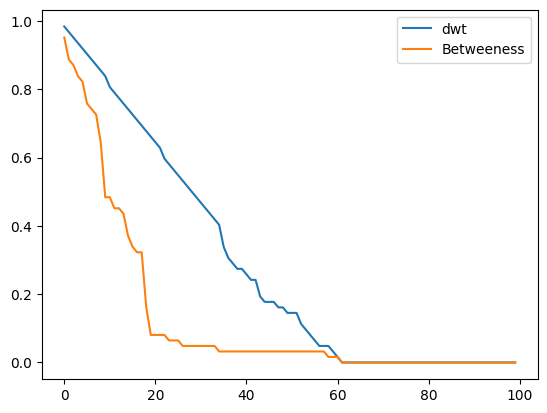

In [102]:
dwt_attack = attack_pro(G, [x[0] for x in dwt_centrality_911])
bet_attack = attack_pro(G, betweeness_nodes)

plt.plot(list(dwt_attack[0].keys()), list(dwt_attack[0].values()), label='dwt')
plt.plot(list(bet_attack[0].keys()), list(bet_attack[0].values()), label='Betweeness')
plt.legend()


In [114]:
import random

def split_community(g:nx.Graph):
    '''
    takes a graph and tries 10 louvain community detections and returns the split with the highest modularity
    '''
    best_modularity = 0
    best_partition = None
    for i in range(10):
        partition = nx.community.louvain_communities(g, seed=random.randint(0, 1000))
        modularity = nx.community.modularity(g, partition)
        if modularity > best_modularity:
            best_modularity = modularity
            best_partition = partition
    return best_partition

def get_boundary_nodes(G, partition):   
    '''
    takes:
        graph and partiton - list of sets of nodes - as input
    
    returns:
        the boundary nodes in a list
    '''
    boundary_edges = set()
    for i in range(len(partition)):
        for j in range(len(partition)):
            if i != j:
                boundary_edges.update(nx.edge_boundary(G, partition[i], partition[j]))

    b_nodes = []
    for i in range(len(boundary_edges)):
        b_nodes.append(list(boundary_edges)[i][0])
        b_nodes.append(list(boundary_edges)[i][1])
    b_nodes = list(set(b_nodes))
    return b_nodes

def _community_attack(g:nx.Graph, partition, centrality_func_bound, centrality_func_internal):
    '''
    takes:
    a graph, a partition, a list of nodes sorted based on their centrality, and a centrality function to recalculate centralities after removal of boundary nodes
    
    returns: 
    LCC, I inex, efficiency, R, InterE, time taken

    ! it requires a helper method: get_boundary_nodes(g, pi)
    ! this itself is a helper method for community_attack(g, centrality_func_bound, centrality_func_internal)
    '''
    G=g.copy(); N=G.number_of_nodes()
    boundary_nodes = get_boundary_nodes(g, partition) ;B=len(boundary_nodes)
    LCC={};Inter={}; Eff={}
    R=[]; InterE=[]

    boundary_sorted = [x[0] for x in sorted(centrality_func_bound(G).items(), key=lambda x: x[1], reverse=True) if x[0] in boundary_nodes]

    t=time.time()
    for i in range(B):
        b_node = boundary_sorted[i]
        G.remove_node(b_node)
        lcc=compute_lcc(G)/N; i_index=compute_i(G, N); eff=nx.algorithms.global_efficiency(G)
        R.append(lcc); InterE.append(eff)
        LCC[i]=lcc; Inter[i]=i_index; Eff[i]=eff

    internal_sorted= [x[0] for x in sorted(centrality_func_internal(G).items(), key=lambda x: x[1], reverse=True) if x[0] not in boundary_nodes]
    for i in range(N-B):
        node = internal_sorted[i]
        G.remove_node(node)
        lcc=compute_lcc(G)/N; i_index=compute_i(G, N); eff=nx.algorithms.global_efficiency(G)
        R.append(lcc); InterE.append(eff)
        LCC[B+i]=lcc; Inter[B+i]=i_index; Eff[B+i]=eff
    
    e=time.time()
    t=e-t
    R=sum(R)/len(R); InterE=sum(InterE)/len(InterE)
    return LCC, Inter, Eff, R, InterE, t, B #returns the number of boundary nodes to highligh them in the plot

def community_attack(g:nx.Graph, centrality_func_bound, centrality_func_internal):
    '''
    Takes:
        a graph, a centrality function to calculate centralities of boundary nodes, and a centrality function to calculate centralities of internal nodes
    Returns:
        LCC, I inex, efficiency, R, InterE, time taken
    
    Runs 10 louvain community detections and uses the split with the highest modularity
    '''
    p = split_community(g)
    return _community_attack(g, p, centrality_func_bound, centrality_func_internal)

def seq_attack(g:nx.Graph, centrality_func, recalculation=False):
    '''
    takes a graph and a centrality function and returns the LCC, I inex, efficiency, R, InterE, time taken
    recalculates centrality after each removal
    '''
    G=g.copy(); N=G.number_of_nodes()
    LCC={};Inter={}; Eff={}
    R=[]; InterE=[]
    
    if recalculation:
        t=time.time()
        for i in range(N):
            sorted_nodes=[x[0] for x in sorted(centrality_func(G).items(), key=lambda x: x[1], reverse=True)]
            node = sorted_nodes[0]
            G.remove_node(node)
            lcc=compute_lcc(G)/N; i_index=compute_i(G, N); eff=nx.algorithms.global_efficiency(G)
            R.append(lcc); InterE.append(eff)
            LCC[i]=lcc; Inter[i]=i_index; Eff[i]=eff
        
        e=time.time()
        t=e-t
        R=sum(R)/len(R); InterE=sum(InterE)/len(InterE)
        return LCC, Inter, Eff, R, InterE, t
    else:
        t=time.time()
        sorted_nodes=[x[0] for x in sorted(centrality_func(G).items(), key=lambda x: x[1], reverse=True)]
        for i in range(N):
            node = sorted_nodes[i]
            G.remove_node(node)
            lcc=compute_lcc(G)/N; i_index=compute_i(G, N); eff=nx.algorithms.global_efficiency(G)
            R.append(lcc); InterE.append(eff)
            LCC[i]=lcc; Inter[i]=i_index; Eff[i]=eff
        
        e=time.time()
        t=e-t
        R=sum(R)/len(R); InterE=sum(InterE)/len(InterE)
        return LCC, Inter, Eff, R, InterE, t

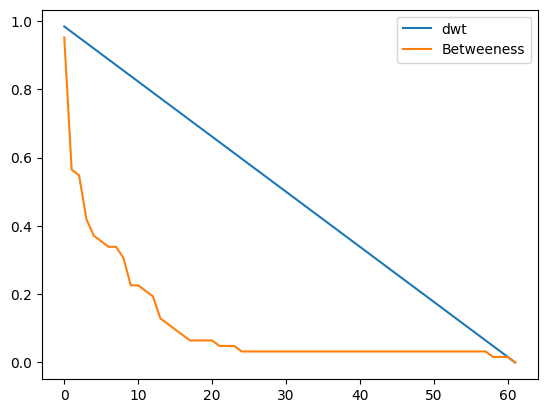

In [109]:
dwt_seq_attack = seq_attack(G, DWT_centrality)
bet_seq_attack = seq_attack(G, nx.betweenness_centrality)

plt.plot(list(dwt_seq_attack[0].keys()), list(dwt_seq_attack[0].values()), label='dwt')
plt.plot(list(bet_seq_attack[0].keys()), list(bet_seq_attack[0].values()), label='Betweeness')
plt.legend()

Text(0, 0.5, 'LCC')

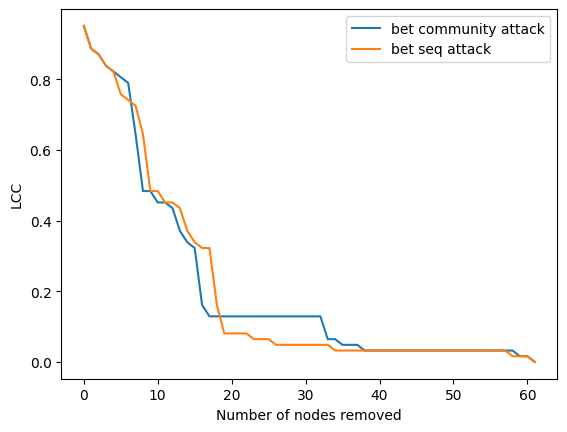

In [115]:
com_bet_bet_attack = community_attack(G, nx.betweenness_centrality, nx.betweenness_centrality)
bet_seq_attack = seq_attack(G, nx.betweenness_centrality)

plt.plot(list(com_bet_bet_attack[0].keys()), list(com_bet_bet_attack[0].values()), label='bet community attack')
plt.plot(list(bet_seq_attack[0].keys()), list(bet_seq_attack[0].values()), label='bet seq attack')
plt.legend()
plt.xlabel('Number of nodes removed')
plt.ylabel('LCC')

In [119]:
bet_time = bet_seq_attack[5]
com_bet_time = com_bet_bet_attack[5]

bet_R= bet_seq_attack[3]
com_bet_R = com_bet_bet_attack[3]

bet_InterE = bet_seq_attack[4]
com_bet_InterE = com_bet_bet_attack[4]

# Create a DataFrame
df = pd.DataFrame({
    'Betweenness Seq': [bet_R, bet_InterE, bet_time],
    'Betweenness Community': [com_bet_R, com_bet_InterE, com_bet_time]
})

# Set the index to the desired row labels
df.index = ["R", "InterE", "Time"]

df


,Betweenness Seq,Betweenness Community
R,0.206296,0.212279
InterE,0.068578,0.080562
Time,0.049867,0.055855


## edge attacks

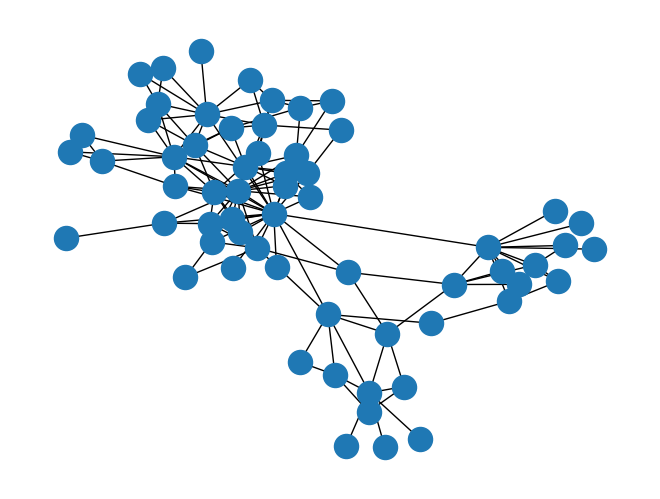

In [131]:
edge_list=[x[0] for x in sorted(nx.edge_betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)]
g=G.copy()
g.remove_edge(edge_list[0][0],edge_list[0][1])
nx.draw(G)

In [130]:
edge_list = nx.edge_betweenness_centrality(G)
edge_list = sorted(edge_list.items(), key=lambda x: x[1], reverse=True)

def seq_attack_edge(g:nx.Graph, centrality_func, recalculation=False):
    '''
    takes a graph and a centrality function and returns the LCC, I inex, efficiency, R, InterE, time taken
    recalculates centrality after each removal (edge removal)
    '''
    G=g.copy(); M=G.number_of_edges()
    LCC={};Inter={}; Eff={}
    R=[]; InterE=[]

    if recalculation:
        t=time.time()
        for i in range(M):
            sorted_edges=[x[0] for x in sorted(centrality_func(G).items(), key=lambda x: x[1], reverse=True)]
            edge_i = sorted_edges[0][0] ; edge_j = sorted_edges[0][1]
            G.remove_node(edge_i, edge_j)
            lcc=compute_lcc(G)/M; i_index=compute_i(G, M); eff=nx.algorithms.global_efficiency(G)
            R.append(lcc); InterE.append(eff)
            LCC[i]=lcc; Inter[i]=i_index; Eff[i]=eff
        
        e=time.time()
        t=e-t
        R=sum(R)/len(R); InterE=sum(InterE)/len(InterE)
        return LCC, Inter, Eff, R, InterE, t
    else:
        t=time.time()
        sorted_edges=[x[0] for x in sorted(centrality_func(G).items(), key=lambda x: x[1], reverse=True)]
        for i in range(M):
            edge_i = sorted_edges[0][0] ; edge_j = sorted_edges[0][1]
            G.remove_edge(edge_i, edge_j)
            lcc=compute_lcc(G)/M; i_index=compute_i(G, M); eff=nx.algorithms.global_efficiency(G)
            R.append(lcc); InterE.append(eff)
            LCC[i]=lcc; Inter[i]=i_index; Eff[i]=eff
        
        e=time.time()
        t=e-t
        R=sum(R)/len(R); InterE=sum(InterE)/len(InterE)
        return LCC, Inter, Eff, R, InterE, t

bet_seq_edge_attack = seq_attack_edge(G, nx.edge_betweenness_centrality)

NetworkXError: The edge 1-11 is not in the graph